# Import the required libraries and files

In [1]:
import pandas as pd
import numpy as np
import fasttext
from scipy.stats import uniform
import pickle
import re
import os

# scikit-learn
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense

# Local Packages
import hats.config
import hats.utility as ut
from hats.data_preprocessing import Preprocessing
import hats.ml_model as ml
from hats.config import CONFIG

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext autoreload
%autoreload 2

In [2]:
home_data = pd.read_csv('../dataset/dataset.csv', sep=';')
translate_data = pd.read_csv('../dataset/translations_data.csv', sep=';')
sms_translations_data = pd.read_csv('../dataset/sms_translations.csv', sep=';')

stop_words = []
with open('../dataset/stop_words.txt') as f:
  stop_words = f.readlines()
  stop_words = [word.replace('\n', '') for word in stop_words]

# Fasttext Model Training 

In [3]:
data_proprocess: Preprocessing = Preprocessing(stop_words, sms_translations_data)
home_data_preprocessed = data_proprocess.preprocessing(home_data.copy())
data_proprocess.saveToCsv(home_data_preprocessed)

# Process the output file to remove double quotes ("")
!sed -i 's/"//g' ../output/comm_preprocessed.txt

In [4]:
# Train a fasttext model in supervised fashion
ft_model = ml.createFasttextModel(CONFIG.OUTPUT_DATASET_FILE)

In [5]:
# Testing the fasttext model
ft_model.get_nearest_neighbors('light')

[(0.9909458756446838, 'batti'),
 (0.9752809405326843, 'balab'),
 (0.970369815826416, 'balb'),
 (0.9694321751594543, 'bulb'),
 (0.961807906627655, 'lights'),
 (0.9222210645675659, 'blb'),
 (0.8873382210731506, 'btti'),
 (0.7504831552505493, 'jla'),
 (0.694067656993866, '</s>'),
 (0.6887581944465637, 'dark')]

In [6]:
ft_model.predict('mai chahta hu ki tum geyser band kr do')

(('__label__geyser_off',), array([0.987086]))

In [7]:
ft_model.get_sentence_vector('mai chahta hu ki tum geyser band kr do').shape

(150,)

# Create additional columns to preprocessed dataset

## 1. Create <i><b>sent_vec</b></i> column in main dataset for sentence vectors

In [11]:
home_data_vectorized = data_proprocess.convertCommandToVector(home_data_preprocessed, ft_model)
home_data_vectorized.head(10)

,commands,label,sent_vec
0,batti bujha,__label__light_off,"[0.23724377, -0.15941232, -0.062567145, -0.179..."
1,balab bujha,__label__light_off,"[0.22000659, -0.1549362, -0.10420093, -0.21526..."
2,balab band,__label__light_off,"[0.34134406, -0.2911445, 0.11321928, -0.001816..."
3,light band,__label__light_off,"[0.41469413, -0.30630016, 0.06520665, -0.06741..."
4,light bujha,__label__light_off,"[0.29335666, -0.17009184, -0.15221357, -0.2808..."
5,light off,__label__light_off,"[0.39077753, -0.2922448, 0.057692014, -0.06030..."
6,dark,__label__light_off,"[0.29366505, -0.18015648, -0.096632324, -0.219..."
7,off light,__label__light_off,"[0.39077753, -0.2922448, 0.057692014, -0.06030..."
8,off light,__label__light_off,"[0.39077753, -0.2922448, 0.057692014, -0.06030..."
9,batti bujhaw,__label__light_off,"[0.22064102, -0.11515682, -0.08981244, -0.1887..."


## 2. Add a column for each class using OVR scheme

After adding the columns, create a single layer perceptron model with 150 inputs and 1 output with sigmoid activation. 

Total number of such models will be equal to the number of classes in the dataset. This is to train multiple models using the OVR technique and while predicting, we will use all the models to predict the final class label of the test command.

In [12]:
home_data_ovr = ut.add_class_ovr_cols(home_data_vectorized.copy())

# Tensorflow Model

In [20]:
models = ml.createPerceptronModels(home_data_ovr['label'].unique())

In [21]:
for m_name in models.keys():
    models[m_name].compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/50
10/10 [==============================] - 0s 26ms/step - loss: 0.2267 - accuracy: 0.9479 - val_loss: 0.2055 - val_accuracy: 0.9167
Epoch 2/50
10/10 [==============================] - 0s 29ms/step - loss: 0.2260 - accuracy: 0.9531 - val_loss: 0.2048 - val_accuracy: 0.9167
Epoch 3/50
10/10 [==============================] - 0s 24ms/step - loss: 0.2254 - accuracy: 0.9531 - val_loss: 0.2040 - val_accuracy: 0.9167
Epoch 4/50
10/10 [==============================] - 0s 15ms/step - loss: 0.2249 - accuracy: 0.9531 - val_loss: 0.2034 - val_accuracy: 0.9167
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 0.2242 - accuracy: 0.9531 - val_loss: 0.2027 - val_accuracy: 0.9167
Epoch 6/50
10/10 [==============================] - 0s 12ms/step - loss: 0.2237 - accuracy: 0.9531 - val_loss: 0.2024 - val_accuracy: 0.9167
Epoch 7/50
10/10 [==============================] - 0s 15ms/step - loss: 0.2230 - accuracy: 0.9531 - val_loss: 0.2021 - val_accuracy: 0.9167
Epoch 8/50
10

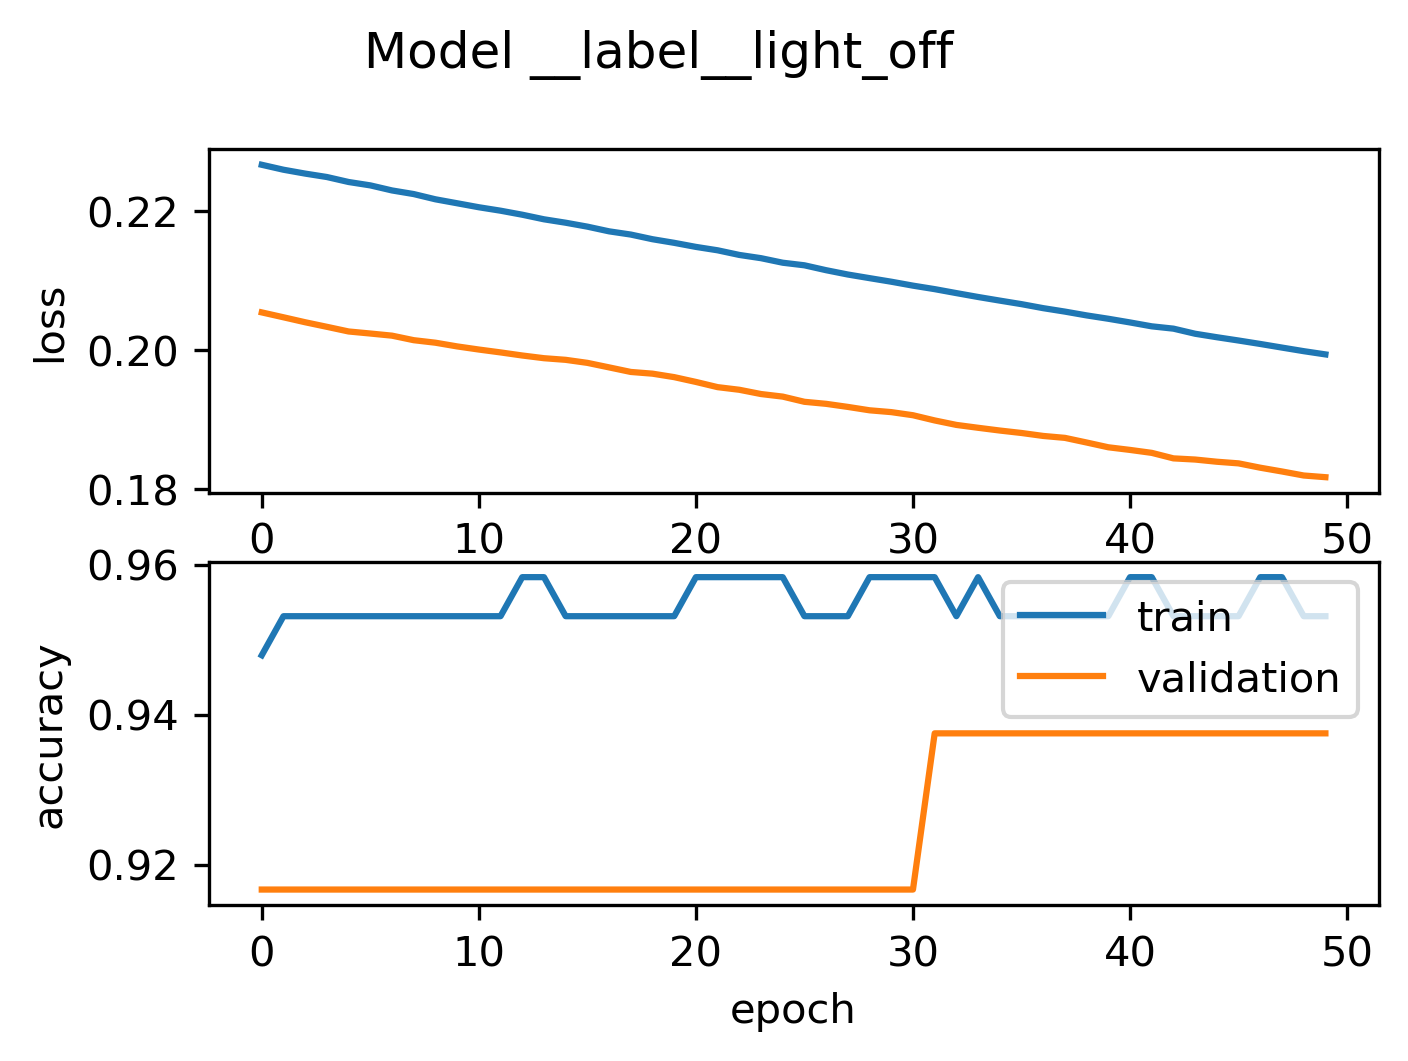

In [27]:
for X_train, X_test, y_train, y_test, label in ut.data_split_classwise(home_data_ovr):
    history = models[label].fit(X_train, y_train, batch_size=20, epochs=50, validation_data=(X_test, y_test))
    ut.plot(history.history, 'Model ' + label, 'plot_' + label + '.png')
    break

# Scikit-learn models

Grid search using SVC

In [13]:
X_train, X_test, y_train, y_test = ut.data_split(home_data_ovr, test_size=0.3)

In [14]:
classifiers = ml.train(X_train, y_train)

 33%|███▎      | 1/3 [00:05<00:10,  5.34s/it]
Model: SVC, Train Accuracy: 1.0
 67%|██████▋   | 2/3 [01:12<00:41, 41.68s/it]
Model: LogisticRegression, Train Accuracy: 1.0
100%|██████████| 3/3 [01:13<00:00, 24.40s/it]
Model: KNeighborsClassifier, Train Accuracy: 1.0



In [15]:
results  = ml.test(classifiers, X_test, y_test)


Model: SVC, Test Accuracy: 1.0

Model: LogisticRegression, Test Accuracy: 1.0

Model: KNeighborsClassifier, Test Accuracy: 1.0


### Plotting the results

<b>Steps:</b>
<ol>
    <li>Create a dictionary of acurracy with the model name as the key and a list of accuracy <code>[train_acc, test_Acc]</code> as its                value.</li>
    <li>Create a DataFrame from this dictionary using the <code>pd.DataFrame.from_dict()</code> method.</li>
    <li>Use the <code>plot()</code> method of the dataframe to plot the data</li>
</ol>

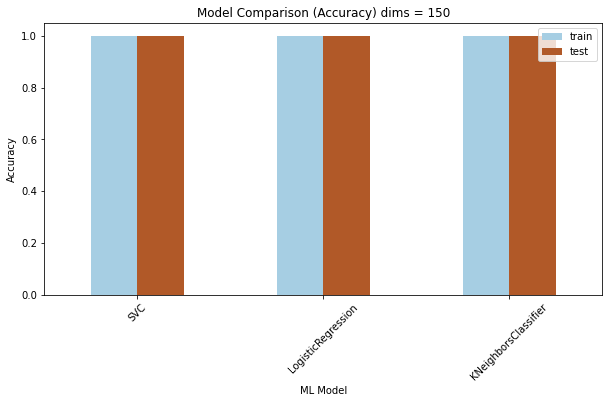

In [16]:
accuracy_scores = {}
for clf_name in classifiers.keys():
    accuracy_scores[clf_name] = np.asarray([classifiers[clf_name]['train_accuracy'], \
        results[clf_name]['test_accuracy']])

accuracy_score_df = pd.DataFrame.from_dict(data=accuracy_scores, orient='index', columns=['train', 'test'])
ax = accuracy_score_df.plot(kind='bar', colormap='Paired', figsize=(10, 5))
plt.xticks(rotation=45)
plt.title(f"Model Comparison (Accuracy) dims = {CONFIG.FT_DIMS}")
plt.xlabel("ML Model")
plt.ylabel("Accuracy")
plt.show()

### Show best estimators for all the models

In [17]:
for clf_name in classifiers:
    print(classifiers[clf_name]['best_estimators'])

SVC(C=0.1, kernel='linear', probability=True, random_state=40)
LogisticRegression(C=0.0001, multi_class='ovr', random_state=40,
                   solver='liblinear')
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4)


In [23]:
ml.cross_validate(classifiers, X_train, X_test, y_train, y_test)

Accuracy SVC - 1.000 (0.0)
Accuracy LogisticRegression - 1.000 (0.0)
Accuracy KNeighborsClassifier - 1.000 (0.0)


In [47]:
test_command = 'gayser on karo ho'
clf = pickle.load(open(classifiers['SVC']['filename'], 'rb'))
for clf_name in classifiers:
    prediction: str = ml.predict(test_command, ft_model, classifiers[clf_name]['filename'])
    print(f"{clf_name} - predicted '{prediction}'")

SVC - predicted 'Other'
LogisticRegression - predicted 'Other'
KNeighborsClassifier - predicted 'Other'


In [46]:
ft_model.get_nearest_neighbors('giser', k=4)
ft_model.predict(test_command)

(('__label__ac_on',), array([0.47008467]))